## 01-BU
INFOSYS722 - Iteration 4 - BDAS
Author: S. Schmidt<br>Date: 10/05/2024<br>
Desc: Primary question: Is the date the UN set of the year 2030 achievable for Goal 2, Zero world hunger?<br><br>
This Spark program reads in the Global Health Index values collected for each country and calculates a Mean value<br>
for each collected year. <br>This mean value is then used to predict the date when "Zero Hunger" will be reached and in turn, provide insight into when Zero Hunger will be reached.


## # 02-DU
Load up libraries and retrieve datasource


In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import sys

#from pyspark.sql.SQLContext import sqlContext
spark = SparkSession.builder.appName('predict_un_ghi_target_date').getOrCreate()
#from pyspark.ml.regression import LinearRegression

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer

#from pyspark.pandas import pypandas
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.linear_model import LinearRegression

print(pd.__version__)


24/05/19 11:32:56 WARN Utils: Your hostname, dev2 resolves to a loopback address: 127.0.1.1; using 192.168.1.217 instead (on interface eth0)
24/05/19 11:32:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/19 11:32:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2.2.2


In [2]:
#platform = sys.platform
#recur_limit = sys.getrecursionlimit()
#print("The recursion limit for %s platform is %s" % (platform, recur_limit))
#sys.setrecursionlimit(1000)
#new_recur_limit = sys.getrecursionlimit()
#print("The new recursion limit for %s platform is %s" % (platform, new_recur_limit))

# Use Spark to read in the Ecommerce Customers csv file. You can infer csv schemas. 
data = spark.read.csv("global-hunger-index.csv",inferSchema=True,header=True)

In [3]:
# Print the schema of the DataFrame. Get a view of the datasource structure
data.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Global Hunger Index (2021): double (nullable = true)
 |-- 411773-annotations: string (nullable = true)



## # 03-DP


In [4]:
# Dump the first 10 instances of the datasource
data.head(10)

[Row(Entity='Afghanistan', Code='AFG', Year=2000, Global Hunger Index (2021)=50.9, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2006, Global Hunger Index (2021)=42.7, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2012, Global Hunger Index (2021)=34.3, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2021, Global Hunger Index (2021)=28.3, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2000, Global Hunger Index (2021)=20.7, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2006, Global Hunger Index (2021)=15.9, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2012, Global Hunger Index (2021)=8.8, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2021, Global Hunger Index (2021)=6.2, 411773-annotations=None),
 Row(Entity='Algeria', Code='DZA', Year=2000, Global Hunger Index (2021)=14.5, 411773-annotations=None),
 Row(Entity='Algeria', Code='DZA', Year=2

In [5]:
# Get a breakdown on info contained in dataframe
data.toPandas().describe()

,Year,Global Hunger Index (2021)
count,471.000000,471.000000
mean,2010.127389,19.824628
std,7.852951,13.449570
min,2000.000000,2.500000
25%,2006.000000,8.800000
50%,2012.000000,17.000000
75%,2021.000000,28.550000
max,2021.000000,65.100000


## 04-DT
Data Transform - Process data source to produce Mean values for each year.

In [6]:
#dRemove unused columns. Not nessary but keeps data clean.
data = data.drop('Code')
data = data.drop('411773-annotations')
data.head(4)

[Row(Entity='Afghanistan', Year=2000, Global Hunger Index (2021)=50.9),
 Row(Entity='Afghanistan', Year=2006, Global Hunger Index (2021)=42.7),
 Row(Entity='Afghanistan', Year=2012, Global Hunger Index (2021)=34.3),
 Row(Entity='Afghanistan', Year=2021, Global Hunger Index (2021)=28.3)]

In [7]:
# Calculate the Mean GHI for each year.
df_raw = data.groupBy("Year").mean("Global Hunger Index (2021)")
df_raw = df_raw.withColumnRenamed("avg(Global Hunger Index (2021))", "MeanGHIraw")
df_raw.show()


+----+-----------------+
|Year|       MeanGHIraw|
+----+-----------------+
|2006|21.04347826086957|
|2012|17.50862068965517|
|2000|24.43928571428571|
|2021|        16.790625|
+----+-----------------+



In [8]:
# Clean up MeanGHI and prep data for SQL
df_raw.summary().show()
df_raw.createOrReplaceTempView("df_Raw_Table")
df = spark.sql("select Year, round(MeanGHIraw, 4) as MeanGHI from df_Raw_Table")
df
df.createOrReplaceTempView("df_Table")


+-------+-----------------+------------------+
|summary|             Year|        MeanGHIraw|
+-------+-----------------+------------------+
|  count|                4|                 4|
|   mean|          2009.75| 19.94550241620261|
| stddev|8.958236433584458|3.5256811798596144|
|    min|             2000|         16.790625|
|    25%|             2000|         16.790625|
|    50%|             2006| 17.50862068965517|
|    75%|             2012| 21.04347826086957|
|    max|             2021| 24.43928571428571|
+-------+-----------------+------------------+



## 05-DMM
Data Transform - Process data source to produce Mean values for each year.

+----+-------+
|Year|MeanGHI|
+----+-------+
|2000|24.4393|
|2006|21.0435|
|2012|17.5086|
|2021|16.7906|
+----+-------+



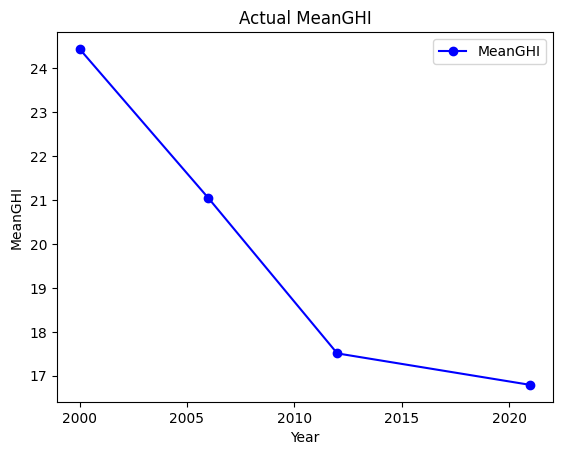

In [9]:
## Data Graphs - Actual MeanGHI
## Plot Initial MeanGHI data
df1=spark.sql("Select * from df_Table order by Year")
df1.show()
pdf1=df1.toPandas()
pdf1.plot(kind='line', x='Year',y='MeanGHI', linestyle="solid", 
          marker="o", color="blue", title="Actual MeanGHI", xlabel='Year', ylabel='MeanGHI')
actual = pdf1

Future predictions are [[24.46248333]
 [20.99713333]
 [17.53178333]
 [12.33375833]]


      Current     Future
2000  24.4393       None
2006  21.0435       None
2012  17.5086  17.531783
2021     None  12.333758


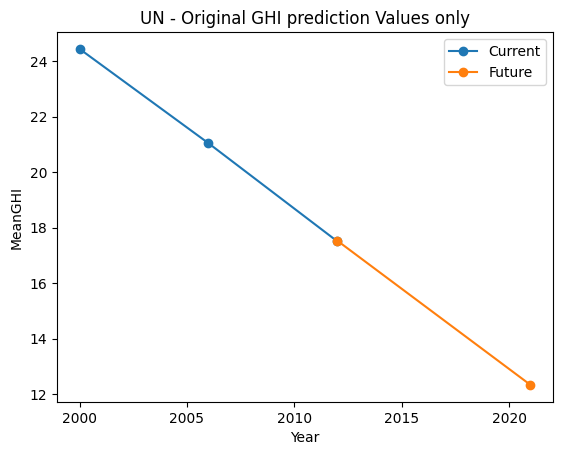

In [10]:
## Data Graphs - UN - Original GHI prediction Values only
## Plot Initial MeanGHI data minus the last reading after COVID
df1b=spark.sql("Select * from df_Table order by Year limit 3")
#df1b.show()
pdf1=df1b.toPandas()

X = np.array(df1b.select("Year").collect())
Y = np.array(df1b.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2000], [2006], [2012], [2021] ]
future = reg.predict(np.array(predict_years))

#future[1] = future[0] 
print("Future predictions are %s" % (future))

columns = ["Year", "MeanGHI"]
new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_2nd=new_row.select("MeanGHI")
plt_2nd = plt_2nd.toPandas().unstack()

#new_data = np.column_stack((predict_years, future))
#new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
#plt_2nd=new_row.select("MeanGHI")
#plt_2nd = future
#.toPandas().unstack()

plt_1st = pdf1['MeanGHI']
plt_1st[3] = 0
plt_2nd = plt_2nd['MeanGHI']
plt_2nd[0] = 0
plt_2nd[1] = 0
#print("plt_1st")
#print(plt_1st)
#print("plt_2nd")
#print(plt_2nd)

df5 = pd.DataFrame({'Current': plt_1st.values,
                    'Future': plt_2nd.values},
                    index=[ 2000, 2006, 2012, 2021 ])


df5 = df5.replace(0, None)

print(df5)

df5.plot(kind='line', title="UN - Original GHI prediction Values only", linestyle="solid", marker="o", xlabel='Year', ylabel='MeanGHI')
origProj_plt_1st = plt_1st
origProj_plt_2nd = plt_2nd

Future predictions are [[24.46248333]
 [20.99713333]
 [17.53178333]
 [12.33375833]]
plt_1st
0    24.4393
1    21.0435
2    17.5086
3     0.0000
Name: MeanGHI, dtype: float64
plt_2nd
0     0.000000
1     0.000000
2    17.531783
3    12.333758
dtype: float64
Actual
   Year  MeanGHI
0  2000  24.4393
1  2006  21.0435
2  2012  17.5086
3  2021  16.7906
       Original   Actual
2000       None  24.4393
2006       None  21.0435
2012  17.531783  17.5086
2021  12.333758  16.7906


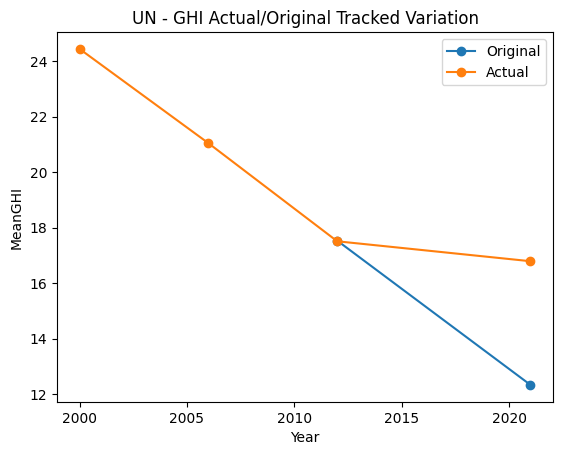

In [11]:
## Data Graphs - UN - Actual v Planned Original GHI Values only (Figure 9)
## Plot Initial MeanGHI data minus the last reading after COVID
df1b=spark.sql("Select * from df_Table order by Year limit 3")
#df1b.show()
pdf1=df1b.toPandas()

X = np.array(df1b.select("Year").collect())
Y = np.array(df1b.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2000], [2006], [2012], [2021] ]
future = reg.predict(np.array(predict_years))

#future[1] = future[0] 
print("Future predictions are %s" % (future))

columns = ["Year", "MeanGHI"]
new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_2nd=new_row.select("MeanGHI")
plt_2nd = plt_2nd.toPandas().unstack()

#new_data = np.column_stack((predict_years, future))
#new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
#plt_2nd=new_row.select("MeanGHI")
#plt_2nd = future
#.toPandas().unstack()

plt_1st = pdf1['MeanGHI']
plt_1st[3] = 0
plt_2nd = plt_2nd['MeanGHI']
plt_2nd[0] = 0
plt_2nd[1] = 0
actual_data = actual['MeanGHI']
print("plt_1st")
print(plt_1st)
print("plt_2nd")
print(plt_2nd)
print("Actual")
print(actual)

df5 = pd.DataFrame({'Original': plt_2nd.values,
                    'Actual': actual_data.values},
                    index=[ 2000, 2006, 2012, 2021 ])


df5 = df5.replace(0, None)

print(df5)

df5.plot(kind='line', title="UN - GHI Actual/Original Tracked Variation", linestyle="solid", marker="o", xlabel='Year', ylabel='MeanGHI')
origProj_plt_1st = plt_1st
origProj_plt_2nd = plt_2nd

Future predictions are [[23.54612336]
 [21.33035514]
 [19.11458692]
 [15.79093458]]
plt_1st
0    24.4393
1    21.0435
2    17.5086
3    16.7906
Name: MeanGHI, dtype: float64
plt_2nd
0    23.546123
1    21.330355
2    19.114587
3    15.790935
dtype: float64
Actual
   Year  MeanGHI
0  2000  24.4393
1  2006  21.0435
2  2012  17.5086
3  2021  16.7906
       Original   Actual
2000  23.546123  24.4393
2006  21.330355  21.0435
2012  19.114587  17.5086
2021  15.790935  16.7906


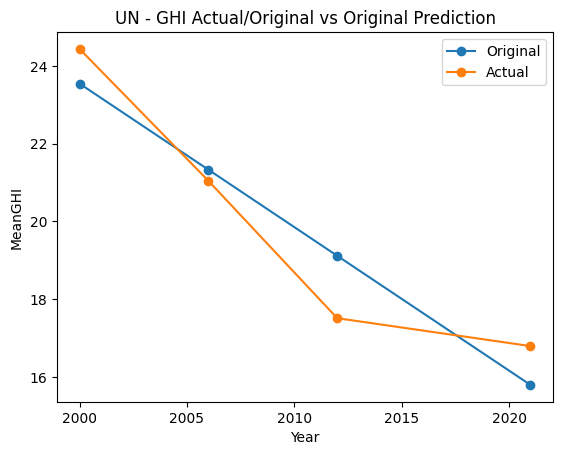

In [12]:
## Data Graphs - UN - Actual v Planned Trend line GHI Prediction (Figure ?)
## Plot Initial MeanGHI data minus the last reading after COVID
df1b=spark.sql("Select * from df_Table order by Year limit 4")
#df1b.show()
pdf1=df1b.toPandas()

X = np.array(df1b.select("Year").collect())
Y = np.array(df1b.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2000], [2006], [2012], [2021] ]
future = reg.predict(np.array(predict_years))

#future[1] = future[0] 
print("Future predictions are %s" % (future))

columns = ["Year", "MeanGHI"]
new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_2nd=new_row.select("MeanGHI")
plt_2nd = plt_2nd.toPandas().unstack()

#new_data = np.column_stack((predict_years, future))
#new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
#plt_2nd=new_row.select("MeanGHI")
#plt_2nd = future
#.toPandas().unstack()

plt_1st = pdf1['MeanGHI']
#plt_1st[3] = 0
plt_2nd = plt_2nd['MeanGHI']
#plt_2nd[0] = 0
#plt_2nd[1] = 0
actual_data = actual['MeanGHI']
print("plt_1st")
print(plt_1st)
print("plt_2nd")
print(plt_2nd)
print("Actual")
print(actual)

df5 = pd.DataFrame({'Original': plt_2nd.values,
                    'Actual': actual_data.values},
                    index=[ 2000, 2006, 2012, 2021 ])


df5 = df5.replace(0, None)

print(df5)

df5.plot(kind='line', title="UN - GHI Actual/Original vs Original Prediction", linestyle="solid", marker="o", xlabel='Year', ylabel='MeanGHI')
origProj_plt_1st = plt_1st
origProj_plt_2nd = plt_2nd

Future predictions are [[23.54612336]
 [21.33035514]
 [19.11458692]
 [15.79093458]
 [13.57516636]
 [11.35939813]
 [ 9.14362991]
 [ 7.66645109]
 [ 5.45068287]
 [ 3.23491464]
 [ 1.01914642]]
plt_1st
0     24.4393
1     21.0435
2     17.5086
3     16.7906
7      0.0000
8      0.0000
9      0.0000
10     0.0000
Name: MeanGHI, dtype: float64
plt_2nd
0     23.546123
1     21.330355
2     19.114587
3     15.790935
4     13.575166
5     11.359398
6      9.143630
7      7.666451
8      5.450683
9      3.234915
10     1.019146
dtype: float64
Actual
   Year  MeanGHI
0  2000  24.4393
1  2006  21.0435
2  2012  17.5086
3  2021  16.7906
      New Predict   Actual
2000    23.546123  24.4393
2006    21.330355  21.0435
2012    19.114587  17.5086
2021    15.790935  16.7906
2027    13.575166     None
2033    11.359398     None
2039     9.143630     None
2043     7.666451     None
2049     5.450683     None
2055     3.234915     None
2061     1.019146     None


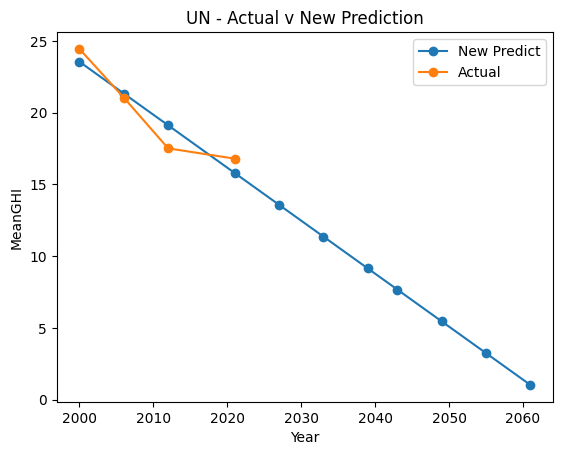

In [13]:
## Data Graphs - UN - Actual v Planned Trend line GHI Prediction (Figure ?)
## Plot Initial MeanGHI data minus the last reading after COVID
df1b=spark.sql("Select * from df_Table order by Year limit 4")
#df1b.show()
pdf1=df1b.toPandas()

X = np.array(df1b.select("Year").collect())
Y = np.array(df1b.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2000], [2006], [2012], [2021], [2027], [2033], [2039], [2043], [2049], [2055], [2061] ]
future = reg.predict(np.array(predict_years))

#future[1] = future[0] 
print("Future predictions are %s" % (future))

columns = ["Year", "MeanGHI"]
new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_2nd=new_row.select("MeanGHI")
plt_2nd = plt_2nd.toPandas().unstack()

#new_data = np.column_stack((predict_years, future))
#new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
#plt_2nd=new_row.select("MeanGHI")
#plt_2nd = future
#.toPandas().unstack()

plt_1st = pdf1['MeanGHI']
#  Init lower part of dataframe first
x = 7
while x<11:
    #print("Init: %s" % (x))
    plt_1st.loc[x]=0
    x += 1

#plt_1st[3] = 0
plt_2nd = plt_2nd['MeanGHI']
#plt_2nd[0] = 0
#plt_2nd[1] = 0
actual_data = actual['MeanGHI']
x = 4
while x<11:
    #print("Init: %s" % (x))
    actual_data.loc[x]=0
    x += 1

print("plt_1st")
print(plt_1st)
print("plt_2nd")
print(plt_2nd)
print("Actual")
print(actual)

df5 = pd.DataFrame({'New Predict': plt_2nd.values,
                    'Actual': actual_data.values},
                    index=[ 2000, 2006, 2012, 2021, 2027, 2033, 2039, 2043, 2049, 2055, 2061 ])


df5 = df5.replace(0, None)

print(df5)

df5.plot(kind='line', title="UN - Actual v New Prediction", linestyle="solid", marker="o", xlabel='Year', ylabel='MeanGHI')
#origProj_plt_1st = plt_1st
#origProj_plt_2nd = plt_2nd
origFullProj_plt_2nd = plt_2nd

         Actual     Future
2000    24.4393       None
2006    21.0435       None
2012    17.5086       None
2021    16.7906       None
2027  13.575166  13.575166
2033       None  11.359398
2039       None    9.14363
2043       None   7.666451
2049       None   5.450683
2055       None   3.234915
2061       None   1.019146


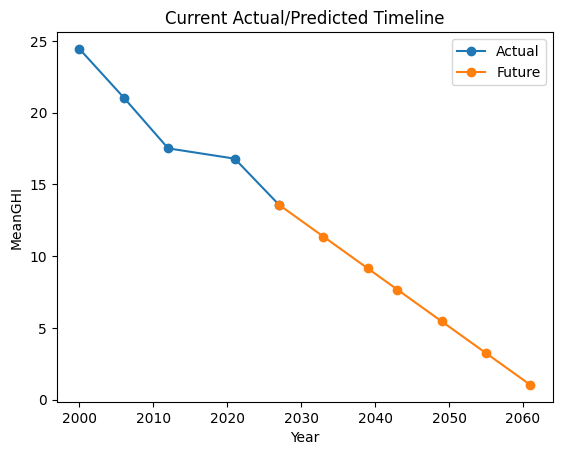

In [14]:
## Data Graphs - Current Future prediction
## Plot Initial MeanGHI data including the reading after COVID projecting out to zero

df2 = spark.sql("Select Year, MeanGHI from df_Table order by Year limit 4")

X = np.array(df2.select("Year").collect())
Y = np.array(df2.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2027], [2033], [2039], [2043], [2049], [2055], [2061] ]
future = reg.predict(np.array(predict_years))
#print("Future predictions are %s" % (future))

plotYears = X
plotMeanGHI = Y
#print("xxxx")
#print(plotYears)
#print(plotMeanGHI)
#print("xxxx")

columns = ["Year", "MeanGHI"]
plt_future = df2
plt_1st=plt_future.select("MeanGHI").toPandas().unstack()

x = 4
while x<11:
    plt_1st.loc['MeanGHI', x]=0
    x += 1

new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_2nd=new_row.select("MeanGHI")
plt_2nd = plt_2nd.toPandas().unstack()

#  Init lower part of dataframe first
x = 7
while x<11:
    #print("Init: %s" % (x))
    plt_2nd.loc['MeanGHI', x]=0
    x += 1

# Rearrange dataframe
x = 10
while x>-1:
    #print("Rearrange: %s" % (x))
    if x<4:
        plt_2nd.loc['MeanGHI',x]=0
    else:
        plt_2nd.loc['MeanGHI',x]=plt_2nd.loc['MeanGHI',(x-4)]
        #print("Value: %s" % (plt_2nd.loc['MeanGHI',(x-4)]))
    x -= 1

# Cross over point
plt_1st.loc['MeanGHI',4]=plt_2nd.loc['MeanGHI',4]

plt_future = plt_future.union(new_row)

#print("....")
#new_row.printSchema()
#new_row.show(truncate=False)
#plt_future.printSchema()
#plt_future.show(truncate=False)
#print("....")

## Plot Initial MeanGHI data
#plt_future.show()
plt_df2=plt_future.toPandas()

#  Convert to series
plt_1st = plt_1st['MeanGHI']
plt_2nd = plt_2nd['MeanGHI']
#print("plt_1st")
#print(plt_1st)
#print("plt_2nd")
#print(plt_2nd)

df5 = pd.DataFrame({'Actual': plt_1st.values,
                    'Future': plt_2nd.values},
                    index=[ 2000, 2006, 2012, 2021, 2027, 2033, 2039, 2043, 2049, 2055, 2061 ])


df5 = df5.replace(0, None)

print(df5)

df5.plot(kind='line', title="Current Actual/Predicted Timeline", linestyle="solid", marker="o", xlabel='Year', ylabel='MeanGHI')
curpredict_1st = plt_1st
curpredict_2nd = plt_2nd

Future predictions are [[ 17.53178333]
 [ 12.33375833]
 [  8.86840833]
 [  5.40305833]
 [  1.93770833]
 [ -0.372525  ]
 [ -3.837875  ]
 [ -7.303225  ]
 [-10.768575  ]]
Init: 7
Init: 8
Init: 9
Init: 10
Rearrange: 10
Rearrange: 9
Rearrange: 8
Rearrange: 7
Rearrange: 6
Rearrange: 5
Rearrange: 4
Rearrange: 3
Rearrange: 2
Rearrange: 1
Rearrange: 0
curpredict_1st
0     24.439300
1     21.043500
2     17.508600
3     16.790600
4     13.575166
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
dtype: float64
curpredict_2nd
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4     13.575166
5     11.359398
6      9.143630
7      7.666451
8      5.450683
9      3.234915
10     1.019146
dtype: float64
plt_1st
MeanGHI  0      0.000000
         1      0.000000
         2     17.531783
         3     12.333758
         4      8.868408
         5      5.403058
         6      1.937708
         7      0.000000
         8      0.000000
         9

<Axes: title={'center': 'Original/Actual/NewPrediction Timelines'}, xlabel='Year', ylabel='MeanGHI'>

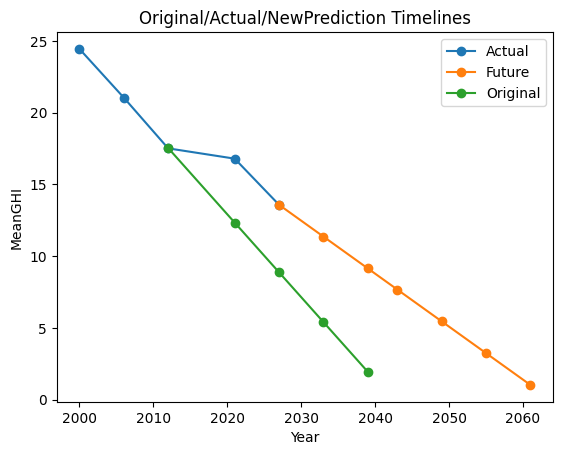

In [25]:
## Data Graphs - Original/Actual/NewPredict
# Example graph

df2 = spark.sql("Select Year, MeanGHI from df_Table order by Year limit 3")

X = np.array(df2.select("Year").collect())
Y = np.array(df2.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2012], [2021], [2027], [2033], [2039], [2043], [2049], [2055], [2061] ]
future = reg.predict(np.array(predict_years))
print("Future predictions are %s" % (future))

plotYears = X
plotMeanGHI = Y
#print("xxxx")
#print(plotYears)
##print(plotMeanGHI)
##print("xxxx")

columns = ["Year", "MeanGHI"]
#plt_future = future
#plt_1st=plt_future.select("MeanGHI").toPandas().unstack()

#x = 4
#while x<11:
#    plt_1st.loc['MeanGHI', x]=0
#    x += 1

new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_1st=new_row.select("MeanGHI")
plt_1st = plt_1st.toPandas().unstack()

#print("plt_1st")
#print(plt_1st)

##  Init lower part of dataframe first
x = 7
while x<11:
    print("Init: %s" % (x))
    plt_1st.loc['MeanGHI', x]=0
    x += 1


## Rearrange dataframe
x = 10
while x>-1:
    print("Rearrange: %s" % (x))
    if x<2:
        plt_1st.loc['MeanGHI',x]=0
    else:
        if plt_1st.loc['MeanGHI',(x-2)]>0:
            plt_1st.loc['MeanGHI',x]=plt_1st.loc['MeanGHI',(x-2)]
        else:
            plt_1st.loc['MeanGHI',x]=0
        #print("Value: %s" % (plt_2nd.loc['MeanGHI',(x-4)]))
    x -= 1

## Cross over point
#plt_1st.loc['MeanGHI',4]=plt_2nd.loc['MeanGHI',4]

#plt_future = plt_future.union(new_row)

##print("....")
##new_row.printSchema()
##new_row.show(truncate=False)
##plt_future.printSchema()
##plt_future.show(truncate=False)
##print("....")

## Plot Initial MeanGHI data
##plt_future.show()
#plt_df2=plt_future.toPandas()

##  Convert to series
#plt_1st = plt_1st['MeanGHI']
#plt_2nd = plt_2nd['MeanGHI']
#print("plt_1st")
#print(plt_1st)
##print("plt_2nd")
##print(plt_2nd)
print("curpredict_1st")
print(curpredict_1st)
print("curpredict_2nd")
print(curpredict_2nd)
print("plt_1st")
print(plt_1st)


df5 = pd.DataFrame({'Actual':   curpredict_1st.values,
                    'Future':   curpredict_2nd.values,
                    #'Original': origpredict_2nd.values},
                    'Original': plt_1st.values},                   
                    index=[ 2000, 2006, 2012, 2021, 2027, 2033, 2039, 2043, 2049, 2055, 2061 ])


df5 = df5.replace(0, None)

#print(df5)

df5.plot(kind='line', title="Original/Actual/NewPrediction Timelines", linestyle="solid", marker="o", xlabel='Year', ylabel='MeanGHI')